In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from mpl_toolkits import mplot3d
from matplotlib import cm
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc
from sklearn.metrics import pairwise_distances
from scipy.stats import wilcoxon, mannwhitneyu
from sklearn.preprocessing import StandardScaler
import copy

In [2]:
data = pd.read_csv("../data/input_data.csv")
data

,Unnamed: 0,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank
0,0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0
1,1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0
2,2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0
3,3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0
4,4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0
...,...,...,...,...,...,...,...,...
57259,57259,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(14, 18]",2718.96,11.0
57260,57260,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(-Infinito, -26]",2693.18,12.0
57261,57261,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(26, Infinito]",2644.22,13.0
57262,57262,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(18, 22]",2525.33,14.0


In [4]:
data = data.drop(["Unnamed: 0"], axis=1)
data

,FEC_HORA_INI,NOM_ELEMENTO,COD_ELEMENTO,NOM_INSTALACION,BIN_YAW,Sum_Of_Avg_W_In_Bin,Yaw_Bin_Rank
0,2020-10-01,002,11267.0,BLUE CREEK,"(26, Infinito]",2819.48,1.0
1,2020-10-01,003,11268.0,BLUE CREEK,"(26, Infinito]",2991.07,1.0
2,2020-10-01,004,11269.0,BLUE CREEK,"(26, Infinito]",2932.53,1.0
3,2020-10-01,005,11270.0,BLUE CREEK,"(26, Infinito]",2937.90,1.0
4,2020-10-01,007,11271.0,BLUE CREEK,"(26, Infinito]",2915.70,1.0
...,...,...,...,...,...,...,...
57259,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(14, 18]",2718.96,11.0
57260,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(-Infinito, -26]",2693.18,12.0
57261,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(26, Infinito]",2644.22,13.0
57262,2020-10-01,Z5,10009.0,LEANING JUNIPER IIA,"(18, 22]",2525.33,14.0


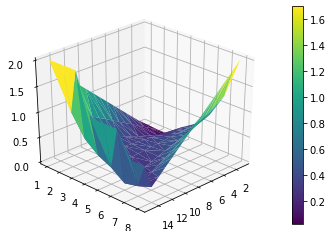

In [14]:
num_ranks = 15
values = [-50, -30, -10, 1, 1.5, 2, 2.5, 3]
dampening_factor = 0.1
severitiy_score = [list() for i in range(num_ranks)]

# first generate all severity scores for only positive bins
# generate alert severity for rank=1

for i in values:
    severity_score[0].append(dampening_factor*np.exp(i))
    
# generate alert severity for rank=1    
severity_score[-1] = sorted(severity_score[0], reverse=True)

# Now generate intermedite severity scores for remaining ranks
delta = [abs((severity_score[0][j] - severity_score[-1][j]) / num_ranks) for j in range(len(values))]


for i in range(1, num_ranks-1):
    # First add till half of bins
    mid = math.ceil(len(values)/2)
    for j in range(mid):
        severity_score[i].append(severity_score[i-1][j]+delta[j])
    for j in range(mid, len(values)):
        severity_score[i].append(severity_score[i-1][j]-delta[j])

             
# Lets plot the severitiy scores for different ranks
# %matplotlib 

fig = plt.figure()
ax = plt.axes(projection="3d")


scoring_function = list()
for i in range(num_ranks):
    for j in range(len(values)):
        scoring_function.append([i+1, j+1, severity_score[i][j]])
scoring_function = np.array(scoring_function)

sev_plot = ax.plot_trisurf(scoring_function[:,0], scoring_function[:,1], scoring_function[:,2], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(sev_plot)
ax.view_init(30, 45)
plt.show()





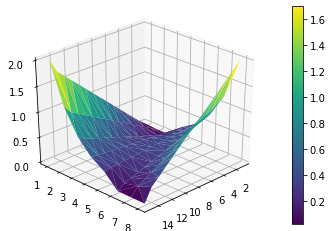

In [15]:
num_ranks = 15
values = [-50, -30, -10, 1, 1.5, 2, 2.5, 3]
dampening_factor = 0.1
severity_score = [list() for i in range(num_ranks)]

# We will first generate all severity scores for only the positive bins
# Generate alert severity for rank=1
for i in values:
    severity_score[0].append(dampening_factor*np.exp(i))

# Generate alert severity for rank=1
severity_score[-1] = sorted(severity_score[0], reverse=True)

# Now generate intermediate severity scores for remaining ranks
delta = [abs((severity_score[0][j] - severity_score[-1][j]) / num_ranks) for j in range(len(values))]
for i in range(1, num_ranks-1):
    # First add till half of bins
    mid = math.ceil(len(values)/2)
    for j in range(mid):
        severity_score[i].append(severity_score[i-1][j]+delta[j])
    for j in range(mid, len(values)):
        severity_score[i].append(severity_score[i-1][j]-delta[j])

        
# Now plot the severity scores for different ranks
# %matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

scoring_function_3d = list()
for i in range(num_ranks):
    for j in range(len(values)):
        scoring_function_3d.append([i+1, j+1, severity_score[i][j]])
scoring_function_3d = np.array(scoring_function_3d)

surf = ax.plot_trisurf(scoring_function_3d[:,0], scoring_function_3d[:,1], scoring_function_3d[:,2], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf)
ax.view_init(30, 45)
plt.show()

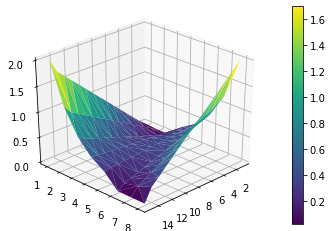

In [12]:
num_ranks = 15
values = [-50, -30, -10, 1, 1.5, 2, 2.5, 3]
dampening_factor = 0.1
severity_score = [list() for i in range(num_ranks)]

# We will first generate all severity scores for only the positive bins
# Generate alert severity for rank=1
for i in values:
    severity_score[0].append(dampening_factor*np.exp(i))

# Generate alert severity for rank=1
severity_score[-1] = sorted(severity_score[0], reverse=True)

# Now generate intermediate severity scores for remaining ranks
delta = [abs((severity_score[0][j] - severity_score[-1][j]) / num_ranks) for j in range(len(values))]
for i in range(1, num_ranks-1):
    # First add till half of bins
    mid = math.ceil(len(values)/2)
    for j in range(mid):
        severity_score[i].append(severity_score[i-1][j]+delta[j])
    for j in range(mid, len(values)):
        severity_score[i].append(severity_score[i-1][j]-delta[j])

        
# Now plot the severity scores for different ranks
# %matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

scoring_function_3d = list()
for i in range(num_ranks):
    for j in range(len(values)):
        scoring_function_3d.append([i+1, j+1, severity_score[i][j]])
scoring_function_3d = np.array(scoring_function_3d)

surf = ax.plot_trisurf(scoring_function_3d[:,0], scoring_function_3d[:,1], scoring_function_3d[:,2], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf)
ax.view_init(30, 45)
plt.show()